# Aircraft Crashes Data Clustering

## Overview

This notebook explores different clustering of aircraft accidents since 1970 and compares the different results. The data has already been cleaned in the [EDA notebook](data_analysis.ipynb).

## Data Preprocessing

In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from yellowbrick.cluster import KElbowVisualizer

In [11]:
# Load data
with open('data/cleaned_data.pkl', 'rb') as handle:
	df = pickle.load(handle)
df.head()

,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,...,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
0,1970-01-02,Accident,Douglas DC-3,Xieng Khouang Air Transport,1951.0,Multi Piston Engines,Unknown,Landing (descent or approach),Cargo,Mountains,...,Laos,Asia,19.111016,102.922537,Destroyed,False,4,4,0.0,Unknown
1,1970-01-02,Accident,Lockheed 18 LodeStar,Sky King Inc.,1943.0,Multi Piston Engines,Unknown,Takeoff (climb),Training,Airport (less than 10 km from airport),...,United States of America,North America,34.832246,-92.259758,Destroyed,True,2,0,0.0,Human factor
2,1970-01-03,Unknown,Fairchild C-123 Provider,United States Air Force - USAF (since 1947),1954.0,Unknown,Unknown,Landing (descent or approach),Military,Airport (less than 10 km from airport),...,Vietnam,Asia,11.576983,108.986539,Unknown,True,5,0,0.0,Technical failure
3,1970-01-05,Accident,Fokker F27 Friendship,Iberia - Lineas Aéreas de Espana,1968.0,Multi Turboprop Engines,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),...,Spain,Europe,28.655116,-17.857269,Destroyed,True,49,0,0.0,Unknown
4,1970-01-05,Accident,Convair CV-990,Spantax,1962.0,Multi Jet Engines,General Electric CJ805-23,Takeoff (climb),Positioning,Airport (less than 10 km from airport),...,Sweden,Europe,59.646792,17.937044,Destroyed,True,10,5,0.0,Human factor


In [12]:
# Split date in three columns
df.insert(0, 'year', df['date'].dt.year)
df.insert(1, 'month', df['date'].dt.month)
df.insert(2, 'day', df['date'].dt.day)
df = df.drop('date', axis=1)
df.head()

,year,month,day,category,type,operator,yom,engine,engine_model,flight_phase,...,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
0,1970,1,2,Accident,Douglas DC-3,Xieng Khouang Air Transport,1951.0,Multi Piston Engines,Unknown,Landing (descent or approach),...,Laos,Asia,19.111016,102.922537,Destroyed,False,4,4,0.0,Unknown
1,1970,1,2,Accident,Lockheed 18 LodeStar,Sky King Inc.,1943.0,Multi Piston Engines,Unknown,Takeoff (climb),...,United States of America,North America,34.832246,-92.259758,Destroyed,True,2,0,0.0,Human factor
2,1970,1,3,Unknown,Fairchild C-123 Provider,United States Air Force - USAF (since 1947),1954.0,Unknown,Unknown,Landing (descent or approach),...,Vietnam,Asia,11.576983,108.986539,Unknown,True,5,0,0.0,Technical failure
3,1970,1,5,Accident,Fokker F27 Friendship,Iberia - Lineas Aéreas de Espana,1968.0,Multi Turboprop Engines,Unknown,Landing (descent or approach),...,Spain,Europe,28.655116,-17.857269,Destroyed,True,49,0,0.0,Unknown
4,1970,1,5,Accident,Convair CV-990,Spantax,1962.0,Multi Jet Engines,General Electric CJ805-23,Takeoff (climb),...,Sweden,Europe,59.646792,17.937044,Destroyed,True,10,5,0.0,Human factor


### Reduce cardinality of string values

In [13]:
# Get string columns with more than 10 unique values
nb_unique = df.select_dtypes(include=['object']).nunique()
string_columns = nb_unique[nb_unique > 10].index
string_columns

Index(['type', 'operator', 'engine_model', 'flight_type', 'location',
       'country'],
      dtype='object')

In [14]:
# Reduce cardinality to 5 by only keeping the most frequent values
for column in string_columns:
  values = list(df[column].value_counts().head(4).index)
  df[column] = np.where(df[column].isin(values), df[column], 'Other')

In [15]:
# Use Ordinal Encoding for category columns
cat_columns = df.select_dtypes(include=['category']).columns
ordinal_encoder = OrdinalEncoder()
encoded_cols = ordinal_encoder.fit_transform(df[cat_columns])
new_df = pd.DataFrame(encoded_cols, columns=ordinal_encoder.get_feature_names_out())
df = df.drop(columns=cat_columns, axis=1).join(new_df)

In [ ]:
# Use One Hot Encoding for other columns
string_columns = df.select_dtypes(include=['object', 'bool']).columns
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cols = onehot_encoder.fit_transform(df[string_columns])
new_df = pd.DataFrame(encoded_cols, columns=onehot_encoder.get_feature_names_out())
df = df.drop(columns=string_columns, axis=1).join(new_df)

In [17]:
# Assert all columns are numeric
assert len(df.columns) == len(df.select_dtypes([np.number]).columns)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12426 entries, 0 to 12425
Data columns (total 61 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   year                                                                  12426 non-null  int32  
 1   month                                                                 12426 non-null  int32  
 2   day                                                                   12426 non-null  int32  
 3   yom                                                                   12426 non-null  float64
 4   latitude                                                              12426 non-null  float64
 5   longitude                                                             12426 non-null  float64
 6   occupants                                                             12426 non-null  int64  


In [19]:
# Export data
df.to_csv('data/preprocessed_data.csv', index=False)

## Feature Engineering

In [27]:
df.shape

(12426, 61)

In [20]:
X = df.copy()

In [ ]:
# Use PCA to reduce dimensionality to half
pca = PCA(n_components=30, whiten=True, random_state=42)
X_pca = pca.fit_transform(X)

In [30]:
X_pca = pd.DataFrame(X_pca, columns=pca.get_feature_names_out())
X_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29
0,1.506196,-0.655822,-0.140950,1.681653,-0.214604,0.280556,-1.628539,1.612958,0.784273,-0.156613,...,0.066470,0.944846,0.292991,-1.130639,0.889206,-1.197149,-1.827167,0.506509,-0.554640,0.317220
1,-0.843969,-0.239000,-0.229654,1.808300,-0.484041,0.613602,-1.536011,1.618888,1.181584,-0.138722,...,0.627975,-0.872545,-0.120443,-0.336198,-0.522247,0.276057,-0.154469,-0.008740,-0.284266,-0.500131
2,1.584409,-0.694929,0.153475,1.563257,-0.442601,0.007907,-1.540864,1.559159,-1.336396,0.066023,...,-0.396407,0.387025,1.226776,-1.035414,-0.013209,-0.216375,-0.945587,-1.511574,1.426705,3.440032
3,0.107381,0.742398,-0.144367,0.867003,-1.507402,-1.142007,-1.380138,1.645549,0.653055,-0.101404,...,-0.835042,-1.056151,-1.062603,0.372491,-0.210720,-0.899740,0.251122,-1.092748,0.375098,-0.579907
4,0.467654,-0.239039,-1.541976,1.095757,-0.205656,-0.569516,-1.350865,1.662215,1.170269,-0.147165,...,0.754167,-0.926179,0.665762,-0.055161,-0.791981,-0.507216,0.420674,0.389675,-0.094758,-0.497111


In [31]:
# Export data
X_pca.to_csv('data/pca_preprocessed_data.csv', index=False)

## Data Modeling

### K-Means

#### Find clusters

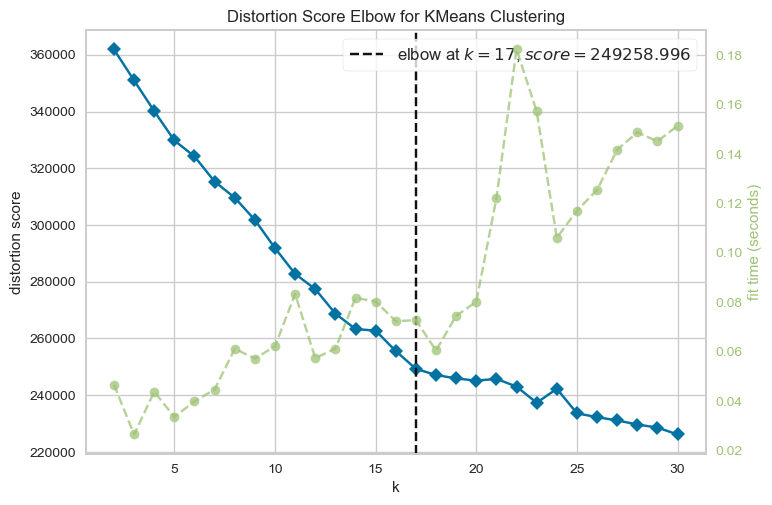

In [32]:
# SSD plot
visualizer = KElbowVisualizer(KMeans(init='k-means++', random_state=42), k=30)
visualizer.fit(X_pca)
visualizer.show();

In [33]:
# Create multiple models for silhouette score
k_values = []
scores = []
for k in range(2, 31):
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
    kmeans.fit(X_pca)
    k_values.append(k)
    scores.append(silhouette_score(X_pca, kmeans.labels_, metric='euclidean'))

models = pd.Series(data=scores, index=k_values)

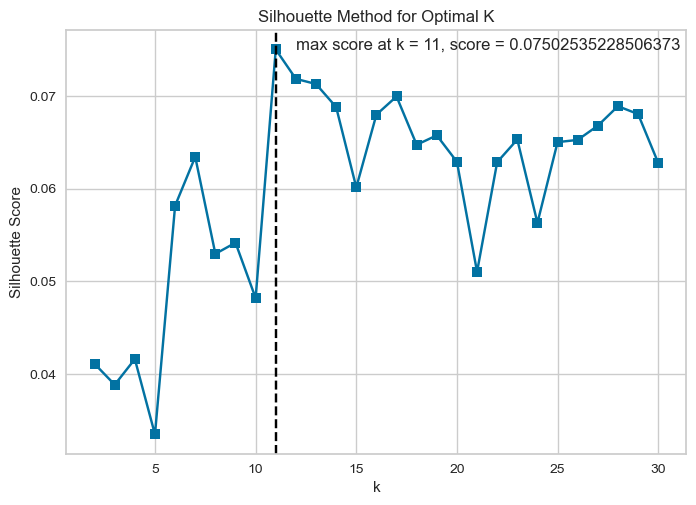

In [34]:
# Silhouette score plot
optimal_k = models.idxmax()
max_score = models.max()

plt.plot(models, marker='s')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal K')
plt.axvline(x=optimal_k, color='black', linestyle='--')
plt.annotate('max score at k = {}, score = {}'.format(optimal_k, max_score), xy=(optimal_k + 1, max_score))
plt.show()

In [35]:
# Based on the silhouette method, the lowest k value to try would be 11
kmeans = KMeans(n_clusters=11, random_state=42)
kmeans.fit(X_pca)

KMeans(n_clusters=11, random_state=42)

In [49]:
original_df = pd.read_csv('data/cleaned_data.csv', parse_dates=['date'])
original_df.insert(0, 'km_cluster', kmeans.labels_)

#### Analyse the clusters

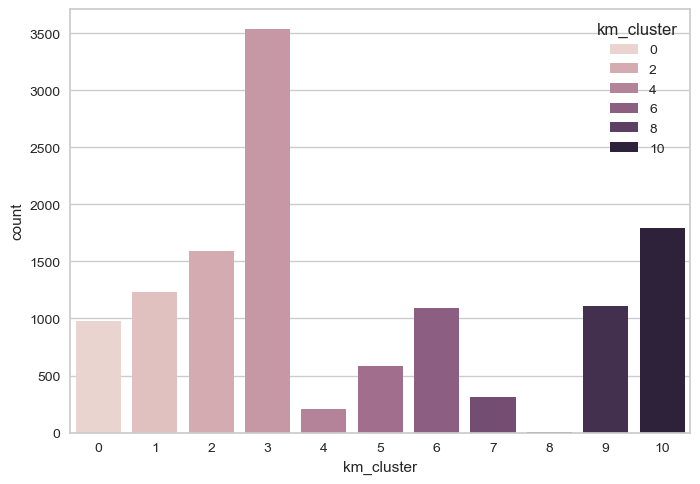

In [50]:
# Plot distribution of the clusters
sns.countplot(data=original_df, x='km_cluster', hue='km_cluster');

In [51]:
km_cluster0 = original_df[original_df['km_cluster'] == 0]
km_cluster0.sample(5)

,km_cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,...,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
8925,0,2002-12-17,Unknown,GAF Nomad N.22,Philippine Air Force - Hukbong Himpapawid NG P...,1977.0,Unknown,Unknown,Landing (descent or approach),Military,...,Philippines,Asia,7.783851,122.588638,Unknown,True,14,0,0.0,Unknown
2514,0,1978-05-12,Unknown,Grumman G-21A Goose,Gifford Aviation,1943.0,Unknown,Unknown,Takeoff (climb),Charter/Taxi (Non Scheduled Revenue Flight),...,United States of America,North America,55.988611,-160.576944,Unknown,True,3,0,0.0,Human factor
11685,0,2018-09-17,Unknown,Ilyushin II-20,Russian Air Force - Voyenno-vozdushnye sily Ro...,1973.0,Multi Turboprop Engines,Unknown,Flight,Survey / Patrol / Reconnaissance,...,Syria,Asia,35.520018,35.778104,Destroyed,False,15,15,0.0,"Terrorism act, hijacking, sabotage, any kind o..."
6971,0,1994-04-24,Accident,Douglas C-47 Skytrain (DC-3),South Pacific Airmotive - SPA,1944.0,Multi Piston Engines,P&W R-1830-92,Takeoff (climb),Charter/Taxi (Non Scheduled Revenue Flight),...,Australia,Oceania,-33.949894,151.181968,Destroyed,True,25,0,0.0,Technical failure
12353,0,2024-07-16,Unknown,Cessna 402,University Research Foundation,1973.0,Unknown,Unknown,Landing (descent or approach),Private,...,United States of America,North America,38.811564,-76.064289,Unknown,False,1,1,0.0,Technical failure


In [52]:
km_cluster0.describe()

,km_cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,978.0,978,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000
mean,0.0,1992-11-13 14:25:46.012269952,1971.518405,22.683029,-36.107861,7.642127,4.929448,0.004090
min,0.0,1970-01-18 00:00:00,1938.000000,-43.535690,-179.491343,0.000000,0.000000,0.000000
25%,0.0,1979-05-19 12:00:00,1960.000000,10.132595,-87.216915,2.000000,0.000000,0.000000
50%,0.0,1990-04-06 00:00:00,1972.000000,24.869313,-70.723997,4.000000,2.000000,0.000000
75%,0.0,2005-06-18 18:00:00,1980.000000,40.795945,17.486165,8.000000,5.000000,0.000000
max,0.0,2025-03-17 00:00:00,2022.000000,74.478705,177.506092,88.000000,88.000000,4.000000
std,0.0,NaN,16.205758,23.422947,87.816856,12.297437,10.880392,0.127906


In [53]:
km_cluster0.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,978,978,978,978,978,978,978,978,978,978,978,978,978,978
unique,3,230,766,6,151,5,27,1,665,108,8,5,2,6
top,Unknown,Britten-Norman Islander,United States Navy - USN,Unknown,Unknown,Flight,Private,"Lake, Sea, Ocean, River","Pacific Ocean, All World",United States of America,North America,Unknown,False,Technical failure
freq,520,35,28,540,682,459,167,978,34,282,282,519,505,328


In [54]:
km_cluster1 = original_df[original_df['km_cluster'] == 1]
km_cluster1.sample(5)

,km_cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,...,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
6047,1,1990-08-29,Accident,Lockheed C-5 Galaxy,United States Air Force - USAF (since 1947),1970.0,Multi Jet Engines,General Electric TF39,Takeoff (climb),Military,...,Germany,Europe,49.441426,7.601240,Destroyed,True,17,13,0.0,Technical failure
970,1,1973-04-06,Accident,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,1962.0,1 Piston engine,Unknown,Flight,Scheduled Revenue Flight,...,Lithuania,Europe,54.686880,25.291021,Destroyed,False,0,0,0.0,Technical failure
1546,1,1975-02-13,Unknown,Cessna 402,Baron Air,1974.0,Unknown,Unknown,Landing (descent or approach),Charter/Taxi (Non Scheduled Revenue Flight),...,Sweden,Europe,26.492533,92.330879,Unknown,True,8,0,0.0,Technical failure
7105,1,1994-12-04,Accident,Cessna 208B Grand Caravan,Air Team,1992.0,1 Turboprop engine,Pratt & Whitney Canada PT6A-114A,Takeoff (climb),Cargo,...,Norway,Europe,60.197865,11.099675,Destroyed,False,1,1,0.0,Weather
4828,1,1986-03-13,Unknown,Piper PA-31 Cheyenne,Private German,1980.0,Unknown,Unknown,Landing (descent or approach),Private,...,United Kingdom,Europe,51.538824,0.712814,Unknown,True,2,1,0.0,Human factor


In [55]:
km_cluster1.describe()

,km_cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,1229.0,1229,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000
mean,1.0,1991-11-01 19:12:56.240846208,1975.053702,48.339805,11.705195,9.531326,3.897478,0.067535
min,1.0,1970-01-05 00:00:00,1929.000000,-5.701408,-98.776234,0.000000,0.000000,0.000000
25%,1.0,1979-06-03 00:00:00,1968.000000,44.780733,1.395574,2.000000,0.000000,0.000000
50%,1.0,1990-01-23 00:00:00,1975.000000,48.571708,9.119583,3.000000,0.000000,0.000000
75%,1.0,2002-06-09 00:00:00,1981.000000,51.977931,19.234781,8.000000,3.000000,0.000000
max,1.0,2025-02-06 00:00:00,2018.000000,76.579033,92.330879,126.000000,84.000000,43.000000
std,0.0,NaN,13.270318,7.472385,20.397734,17.087961,10.480363,1.288067


In [56]:
km_cluster1.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,1229,1229,1229,1229,1229,1229,1229,1229,1229,1229,1229,1229,1229,1229
unique,3,255,758,6,196,6,29,6,835,47,2,5,2,6
top,Accident,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,Unknown,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Zurich-Kloten, Zurich",France,Europe,Destroyed,True,Human factor
freq,678,138,77,568,793,631,226,849,11,180,1213,619,633,565


In [57]:
km_cluster2 = original_df[original_df['km_cluster'] == 2]
km_cluster2.sample(5)

,km_cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,...,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
4853,2,1986-05-01,Unknown,Partenavia P.68,Wildlife & Fisheries,1983.0,Unknown,Unknown,Flight,Private,...,United States of America,North America,30.871859,-92.014285,Unknown,False,1,1,0.0,Human factor
707,2,1972-06-28,Accident,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,1972.0,1 Piston engine,Unknown,Flight,Spraying (Agricultural),...,Kazakhstan,Asia,44.842678,65.503615,Destroyed,True,2,0,0.0,Human factor
2925,2,1979-07-13,Accident,Douglas DC-3,M. J. Supply Inc.,1939.0,Multi Piston Engines,Unknown,Flight,Ferry,...,United States of America,North America,26.684510,-80.667558,Destroyed,True,2,0,0.0,Technical failure
10249,2,2009-12-04,Unknown,Piper PA-31 Cheyenne,Cheyenne Sales & Leasing,1981.0,Unknown,Unknown,Flight,Ferry,...,United States of America,North America,44.019219,-84.799787,Unknown,False,1,1,0.0,Technical failure
4356,2,1984-07-04,Unknown,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,1973.0,Unknown,Unknown,Flight,Charter/Taxi (Non Scheduled Revenue Flight),...,Kazakhstan,Asia,49.816128,73.102662,Unknown,True,6,2,0.0,Human factor


In [58]:
km_cluster2.describe()

,km_cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,1592.0,1592,1592.000000,1592.000000,1592.000000,1592.000000,1592.000000,1592.000000
mean,2.0,1991-07-19 23:51:51.557788928,1971.708543,29.887365,-19.751659,5.185302,3.798995,0.010050
min,2.0,1970-01-31 00:00:00,1928.000000,-45.895193,-179.491343,0.000000,0.000000,0.000000
25%,2.0,1978-12-10 00:00:00,1964.000000,19.142898,-95.422713,1.000000,0.000000,0.000000
50%,2.0,1987-09-03 00:00:00,1972.000000,34.705606,-77.849233,2.000000,1.000000,0.000000
75%,2.0,2002-06-19 12:00:00,1980.000000,43.799892,55.911186,5.000000,4.000000,0.000000
max,2.0,2025-03-13 00:00:00,2021.000000,77.723103,178.719537,158.000000,81.000000,7.000000
std,0.0,NaN,14.116708,23.115631,91.389281,9.929682,8.633238,0.221189


In [59]:
km_cluster2.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,1592,1592,1592,1592,1592,1592,1592,1592,1592,1592,1592,1592,1592,1592
unique,3,239,1072,6,147,4,32,1,1401,86,6,5,2,6
top,Unknown,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,Unknown,Unknown,Flight,Private,"Plain, Valley","Kenai, Alaska",United States of America,North America,Unknown,False,Human factor
freq,993,234,208,1010,1280,1195,257,1592,6,718,718,967,1078,672


In [60]:
km_cluster3 = original_df[original_df['km_cluster'] == 3]
km_cluster3.sample(5)

,km_cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,...,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
6919,3,1994-01-26,Unknown,Cessna 421C Golden Eagle III,Sky Harbor Air Service,1976.0,Unknown,Unknown,Landing (descent or approach),Charter/Taxi (Non Scheduled Revenue Flight),...,United States of America,North America,40.207049,-100.591658,Unknown,True,7,2,0.0,Human factor
10115,3,2009-02-12,Accident,De Havilland DHC-8-400 (Dash-8),Continental Connection,2008.0,Multi Turboprop Engines,Pratt & Whitney Canada PW150A,Landing (descent or approach),Scheduled Revenue Flight,...,United States of America,North America,42.886717,-78.878392,Destroyed,False,49,49,1.0,Human factor
5310,3,1987-12-31,Unknown,Britten-Norman Islander,Aero Taxco,1985.0,Unknown,Unknown,Unknown,Charter/Taxi (Non Scheduled Revenue Flight),...,Mexico,Central America,23.916137,-102.250775,Unknown,False,0,0,0.0,Unknown
9519,3,2006-02-03,Unknown,De Havilland DH.104 Dove,Private New Zealand,1953.0,Unknown,Unknown,Landing (descent or approach),Private,...,New Zealand,Oceania,26.492533,92.330879,Unknown,True,9,0,0.0,Technical failure
9491,3,2005-11-29,Unknown,Cessna 425 Conquest,Tech II,1981.0,Unknown,Unknown,Landing (descent or approach),Private,...,United States of America,North America,45.679429,-111.044047,Unknown,False,1,1,0.0,Human factor


In [61]:
km_cluster3.describe()

,km_cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,3534.0,3534,3534.000000,3534.000000,3534.000000,3534.000000,3534.000000,3534.000000
mean,3.0,1993-11-15 13:28:00.814940544,1973.672892,27.151180,-17.736075,9.078664,2.862762,0.101868
min,3.0,1970-01-03 00:00:00,1927.000000,-77.833779,-171.727949,0.000000,0.000000,0.000000
25%,3.0,1980-10-27 12:00:00,1966.000000,15.389695,-90.376011,2.000000,0.000000,0.000000
50%,3.0,1992-10-11 12:00:00,1974.000000,31.730530,-71.671652,3.000000,0.000000,0.000000
75%,3.0,2005-11-11 00:00:00,1981.000000,40.446377,54.745170,8.000000,2.000000,0.000000
max,3.0,2025-03-07 00:00:00,2022.000000,80.916649,177.506092,118.000000,75.000000,35.000000
std,0.0,NaN,14.671455,20.592975,89.152703,15.596019,7.989882,1.208205


In [62]:
km_cluster3.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,3534,3534,3534,3534,3534,3534,3534,3534,3534,3534,3534,3534,3534,3534
unique,5,369,2345,7,421,5,30,4,2233,133,7,7,2,6
top,Accident,Antonov AN-12,Aeroflot - Russian International Airlines,Unknown,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Kinshasa-N'Djili, Kinshasa City Province",United States of America,North America,Destroyed,True,Human factor
freq,1912,100,145,1688,2111,3138,760,3283,17,1634,1634,1568,2130,1898


In [63]:
km_cluster4 = original_df[original_df['km_cluster'] == 4]
km_cluster4.sample(5)

,km_cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,...,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
9146,4,2004-01-03,Accident,Boeing 737-300,Flash Airlines,1992.0,Multi Jet Engines,CFMI CFM56-3C1,Takeoff (climb),Charter/Taxi (Non Scheduled Revenue Flight),...,Egypt,Africa,27.864442,34.295447,Destroyed,False,148,148,0.0,Human factor
8436,4,2000-07-25,Accident,Aérospatiale-BAC Concorde,Air France,1975.0,Multi Jet Engines,Rolls-Royce Olympus 593/610,Takeoff (climb),Charter/Taxi (Non Scheduled Revenue Flight),...,France,Europe,48.986356,2.450054,Destroyed,False,109,109,4.0,Technical failure
4757,4,1985-12-12,Accident,Douglas DC-8,Arrow Air,1969.0,Multi Jet Engines,P&W JT3D-7,Takeoff (climb),Charter/Taxi (Non Scheduled Revenue Flight),...,Canada,North America,48.959229,-54.618788,Destroyed,False,256,256,0.0,Unknown
9046,4,2003-07-08,Accident,Boeing 737-200,Sudan Airways,1975.0,Multi Jet Engines,P&W JT8D-7,Landing (descent or approach),Scheduled Revenue Flight,...,Sudan,Africa,19.610333,37.220324,Destroyed,True,117,116,0.0,Technical failure
2387,4,1978-01-01,Accident,Boeing 747-200,Air India,1971.0,Multi Jet Engines,P&W JT9D-7J,Takeoff (climb),Scheduled Revenue Flight,...,India,Asia,19.097420,72.862666,Destroyed,False,213,213,0.0,Human factor


In [64]:
km_cluster4.describe()

,km_cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,206.0,206,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000
mean,4.0,1991-11-14 10:22:08.155339776,1978.951456,27.446009,25.876922,147.665049,140.383495,1.208738
min,4.0,1970-02-06 00:00:00,1958.000000,-27.267429,-170.715969,75.000000,72.000000,0.000000
25%,4.0,1978-11-16 00:00:00,1969.000000,12.926857,-5.049423,104.250000,100.000000,0.000000
50%,4.0,1992-04-25 12:00:00,1977.000000,32.346739,35.407047,126.500000,117.000000,0.000000
75%,4.0,2002-05-20 12:00:00,1987.000000,42.192594,77.120269,167.000000,158.750000,0.000000
max,4.0,2024-12-29 00:00:00,2018.000000,78.223156,144.800835,524.000000,520.000000,49.000000
std,0.0,NaN,12.944066,20.237188,66.812800,64.816284,62.937084,5.610975


In [65]:
km_cluster4.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,206,206,206,206,206,206,206,206,206,206,206,206,206,206
unique,3,54,138,3,109,4,5,6,179,67,8,2,2,6
top,Accident,Boeing 737-200,Aeroflot - Russian International Airlines,Multi Jet Engines,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Tenerife-Norte-Los Rodeos, Canary Islands",Russia,Asia,Destroyed,False,Human factor
freq,177,17,20,176,22,108,160,86,4,23,100,196,142,126


In [66]:
km_cluster5 = original_df[original_df['km_cluster'] == 5]
km_cluster5.sample(5)

,km_cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,...,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
9008,5,2003-04-23,Accident,Beechcraft 99 Airliner,Transwest Air,1969.0,Multi Turboprop Engines,Pratt & Whitney Canada PT6A-27,Landing (descent or approach),Scheduled Revenue Flight,...,Canada,North America,53.201097,-105.748901,Destroyed,True,6,0,0.0,Human factor
2798,5,1979-02-23,Unknown,De Havilland DHC-2 Beaver,Cargair,1956.0,Unknown,Unknown,Landing (descent or approach),Cargo,...,Canada,North America,55.281343,-77.758465,Unknown,False,1,1,0.0,Human factor
12279,5,2023-11-27,Unknown,Mitsubishi MU-2 Marquise,Thunder Airlines,1982.0,Unknown,Unknown,Landing (descent or approach),Ambulance,...,Canada,North America,47.992928,-84.774020,Unknown,True,3,0,0.0,Human factor
705,5,1972-06-24,Unknown,Beechcraft D18,Ilford Riverton Airways,1946.0,Unknown,Unknown,Takeoff (climb),Charter/Taxi (Non Scheduled Revenue Flight),...,Canada,North America,49.895537,-97.138458,Unknown,False,9,9,0.0,Technical failure
1936,5,1976-07-23,Accident,De Havilland DHC-3 Otter,Ontario Ministry of Natural Resources,1956.0,1 Piston engine,Unknown,Takeoff (climb),Government,...,Canada,North America,48.693114,-91.469862,Destroyed,True,5,0,0.0,Human factor


In [67]:
km_cluster5.describe()

,km_cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,581.0,581,581.000000,581.000000,581.000000,581.000000,581.000000,581.0
mean,5.0,1994-02-01 05:12:17.349397632,1965.870912,52.650197,-95.687207,5.593804,1.848537,0.0
min,5.0,1970-03-28 00:00:00,1938.000000,-3.345586,-140.179101,0.000000,0.000000,0.0
25%,5.0,1981-04-14 00:00:00,1953.000000,49.126328,-120.339415,2.000000,0.000000,0.0
50%,5.0,1993-12-06 00:00:00,1967.000000,51.464814,-95.376295,3.000000,1.000000,0.0
75%,5.0,2005-06-24 00:00:00,1976.000000,55.743347,-76.428334,6.000000,2.000000,0.0
max,5.0,2025-02-17 00:00:00,2017.000000,82.525369,103.412702,119.000000,42.000000,0.0
std,0.0,NaN,15.852734,7.051453,30.117625,10.164860,3.106354,0.0


In [68]:
km_cluster5.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,581,581,581,581,581,581,581,581,581,581,581,581,581,581
unique,2,127,369,6,87,6,22,6,401,1,1,5,2,6
top,Accident,De Havilland DHC-2 Beaver,Royal Canadian Air Force - RCAF,Unknown,Unknown,Landing (descent or approach),Charter/Taxi (Non Scheduled Revenue Flight),Airport (less than 10 km from airport),"Pickle Lake, Ontario",Canada,North America,Unknown,True,Human factor
freq,292,90,14,321,370,269,148,294,7,581,581,287,354,256


In [69]:
km_cluster6 = original_df[original_df['km_cluster'] == 6]
km_cluster6.sample(5)

,km_cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,...,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
2742,6,1978-12-26,Accident,Learjet 25,TAM Brasil - Taxi Aéreo Marilia - Transportes ...,1973.0,Multi Jet Engines,Unknown,Takeoff (climb),Charter/Taxi (Non Scheduled Revenue Flight),...,Brazil,South America,-23.627415,-46.655561,Destroyed,True,6,0,0.0,Technical failure
3105,6,1980-02-01,Unknown,Piper PA-31 Cheyenne,Instituto Nacional de Tecnología Agropecuaria ...,1979.0,Unknown,Unknown,Flight,Government,...,Argentina,South America,-34.095471,-59.024510,Unknown,False,3,3,0.0,Unknown
2674,6,1978-10-17,Unknown,Britten-Norman Islander,ATESA - Aero Taxis Ecuatorianos,1977.0,Multi Piston Engines,Unknown,Flight,Scheduled Revenue Flight,...,Ecuador,South America,-1.486260,-78.101726,Destroyed,False,0,0,0.0,Unknown
7236,6,1995-05-15,Accident,De Havilland DHC-5 Buffalo,Brazilian Air Force - Força Aérea Brasileira (...,1969.0,Multi Turboprop Engines,Unknown,Landing (descent or approach),Training,...,Brazil,South America,-3.145056,-59.985613,Destroyed,False,0,0,0.0,Unknown
3867,6,1982-08-04,Accident,Boeing 727-100,Aerotal Colombia - Aerolineas Territoriales de...,1966.0,Multi Jet Engines,Pratt & Whitney JT8D-7,Landing (descent or approach),Scheduled Revenue Flight,...,Colombia,South America,11.118892,-74.231189,Destroyed,True,50,0,0.0,Human factor


In [70]:
km_cluster6.describe()

,km_cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,1089.0,1089,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,6.0,1993-07-10 06:27:26.280991744,1971.162534,-10.691454,-63.003421,10.696051,4.037649,0.149679
min,6.0,1970-01-31 00:00:00,1938.000000,-89.991843,-179.491343,0.000000,0.000000,0.000000
25%,6.0,1979-09-15 00:00:00,1959.000000,-23.006022,-73.620152,2.000000,0.000000,0.000000
50%,6.0,1992-08-18 00:00:00,1973.000000,-10.175806,-66.736878,5.000000,1.000000,0.000000
75%,6.0,2005-06-06 00:00:00,1981.000000,4.610017,-54.934619,10.000000,4.000000,0.000000
max,6.0,2025-03-04 00:00:00,2023.000000,68.930470,92.330879,100.000000,80.000000,30.000000
std,0.0,NaN,16.502847,16.859305,16.667426,17.157370,9.026995,1.506299


In [71]:
km_cluster6.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089
unique,4,203,565,6,137,6,26,7,625,16,4,6,2,6
top,Accident,Douglas C-47 Skytrain (DC-3),Brazilian Air Force - Força Aérea Brasileira (...,Unknown,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Bogotá-El Dorado, Bogotá Capital District",Brazil,South America,Destroyed,True,Unknown
freq,652,53,42,459,700,535,244,689,38,322,1082,587,573,362


In [72]:
km_cluster7 = original_df[original_df['km_cluster'] == 7]
km_cluster7.sample(5)

,km_cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,...,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
5806,7,1989-10-02,Accident,Boeing 737-200,Nigeria Airways,1982.0,Multi Jet Engines,Pratt & Whitney JT8D-15,Landing (descent or approach),Scheduled Revenue Flight,...,Nigeria,Africa,6.553863,3.325571,Destroyed,True,135,0,0.0,Unknown
3455,7,1981-02-17,Accident,Boeing 737-200,Air California - Air Cal,1970.0,Multi Jet Engines,Pratt & Whitney JT8D-7A,Landing (descent or approach),Scheduled Revenue Flight,...,United States of America,North America,33.674205,-117.868024,Destroyed,True,110,0,0.0,Human factor
8432,7,2000-07-18,Accident,Fokker F28 Fellowship,Iran Aseman Airlines,1981.0,Multi Jet Engines,Rolls-Royce Spey 555-15H,Landing (descent or approach),Scheduled Revenue Flight,...,Iran,Asia,31.323064,48.679320,Destroyed,True,88,0,0.0,Human factor
1284,7,1974-03-15,Accident,Sud-Aviation SE-210 Caravelle,Sterling Airways,1970.0,Multi Jet Engines,Pratt & Whitney JT8D-9,Taxiing,Scheduled Revenue Flight,...,Iran,Asia,35.785383,51.300580,Destroyed,True,96,15,0.0,Technical failure
472,7,1971-09-06,Accident,BAc 111,Paninternational,1970.0,Multi Jet Engines,Rolls-Royce Spey 512-14 DW,Takeoff (climb),Charter/Taxi (Non Scheduled Revenue Flight),...,Germany,Europe,53.636362,9.994550,Destroyed,True,121,22,0.0,Technical failure


In [73]:
km_cluster7.describe()

,km_cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,314.0,314,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,7.0,1998-12-28 03:12:36.687898112,1983.289809,26.014823,19.755538,155.955414,2.726115,0.082803
min,7.0,1970-08-08 00:00:00,1953.000000,-34.816320,-156.472712,80.000000,0.000000,0.000000
25%,7.0,1988-07-12 12:00:00,1973.000000,14.512302,-62.305343,111.250000,0.000000,0.000000
50%,7.0,2000-01-16 12:00:00,1981.000000,29.855435,30.703024,138.000000,0.000000,0.000000
75%,7.0,2010-08-11 06:00:00,1992.750000,40.642948,77.084061,172.000000,0.000000,0.000000
max,7.0,2025-01-28 00:00:00,2021.000000,66.001113,144.800835,468.000000,111.000000,8.000000
std,0.0,NaN,13.271872,20.272555,76.196194,65.190342,10.170817,0.592410


In [74]:
km_cluster7.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,314,314,314,314,314,314,314,314,314,314,314,314,314,314
unique,3,61,180,4,124,5,6,5,243,87,6,4,1,6
top,Accident,Boeing 737-200,Aeroflot - Russian International Airlines,Multi Jet Engines,CFMI CFM56-3C1,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Mashhad, Razavi Khorasan",United States of America,Asia,Destroyed,True,Human factor
freq,296,34,20,292,22,238,277,302,5,45,157,195,314,169


In [76]:
km_cluster8 = original_df[original_df['km_cluster'] == 8]
km_cluster8

,km_cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,...,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
2001,8,1976-10-13,Accident,Boeing 707,Lloyd Aéreo Boliviano - LAB Airlines,1959.0,Multi Jet Engines,Pratt & Whitney JT3C-,Takeoff (climb),Cargo,...,Bolivia,South America,-17.797198,-63.166809,Destroyed,False,3,3,110.0,Human factor
2812,8,1979-03-14,Accident,Hawker Siddeley HS.121 Trident,CAAC - Civil Aviation Administration of China,1976.0,Multi Jet Engines,Rolls-Royce Spey 512,Takeoff (climb),Training,...,China,Asia,39.958674,116.253759,Destroyed,False,12,12,180.0,Human factor
8811,8,2002-05-04,Accident,BAc 111,EAS Airlines - Executive Airline Services,1980.0,Multi Jet Engines,Rolls-Royce Spey 512-14DW,Takeoff (climb),Scheduled Revenue Flight,...,Nigeria,Africa,11.993998,8.521974,Destroyed,False,79,79,78.0,Human factor


In [78]:
km_cluster9 = original_df[original_df['km_cluster'] == 9]
km_cluster9.sample(5)

,km_cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,...,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
4385,9,1984-08-02,Unknown,Piper PA-31-350 Navajo Chieftain,Sac Air,1979.0,Unknown,Unknown,Flight,Private,...,United States of America,North America,36.095911,-84.442434,Unknown,False,2,2,0.0,Human factor
11348,9,2016-04-06,Accident,BAe 125,Japan Air Self-Defense Force - Kōkū Jieitai,1993.0,Unknown,Unknown,Landing (descent or approach),Calibration,...,Japan,Asia,31.377711,130.833349,Destroyed,False,6,6,0.0,Human factor
10218,9,2009-10-13,Accident,Beechcraft C-12 Huron,United States Army,1978.0,Unknown,Unknown,Flight,Survey / Patrol / Reconnaissance,...,Afghanistan,Asia,35.419089,70.327727,Destroyed,False,3,3,0.0,Human factor
8465,9,2000-09-02,Accident,Basler BT-67,Colombian Air Force - Fuerza Aérea Colombiana,1945.0,Multi Piston Engines,Unknown,Flight,Military,...,Colombia,South America,5.221583,-76.030209,Destroyed,False,7,7,0.0,Human factor
3686,9,1981-11-25,Unknown,Max Holste M.H.1521M Broussard,French Air Force - Armée de l'Air,1959.0,Unknown,Unknown,Flight,Military,...,France,Europe,45.271100,5.964270,Unknown,False,0,0,0.0,Unknown


In [79]:
km_cluster9.describe()

,km_cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,1111.0,1111,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.0
mean,9.0,1992-04-12 22:09:49.738973952,1972.497750,24.521240,-23.136489,9.411341,8.627363,0.0
min,9.0,1970-01-02 00:00:00,1900.000000,-83.899927,-176.102104,0.000000,0.000000,0.0
25%,9.0,1980-05-29 00:00:00,1963.000000,5.305150,-105.468675,2.000000,2.000000,0.0
50%,9.0,1990-05-11 00:00:00,1973.000000,34.041390,-67.080622,5.000000,4.000000,0.0
75%,9.0,2002-12-16 00:00:00,1981.000000,42.834498,47.514455,10.000000,9.000000,0.0
max,9.0,2025-01-08 00:00:00,2021.000000,69.344405,177.288210,92.000000,91.000000,0.0
std,0.0,NaN,14.421448,26.011492,94.279418,13.232060,12.906585,0.0


In [80]:
km_cluster9.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,1111,1111,1111,1111,1111,1111,1111,1111,1111,1111,1111,1111,1111,1111
unique,3,210,798,6,143,3,30,1,976,101,8,6,2,6
top,Accident,De Havilland DHC-6 Twin Otter,Aeroflot - Russian International Airlines,Unknown,Unknown,Flight,Scheduled Revenue Flight,Mountains,"Sitka, Alaska",United States of America,North America,Destroyed,False,Human factor
freq,579,50,63,568,753,836,228,1111,6,345,345,561,937,774


In [81]:
km_cluster10 = original_df[original_df['km_cluster'] == 10]
km_cluster10.sample(5)

,km_cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,...,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
4533,10,1985-02-06,Unknown,Cessna 402,Altus Airlines,1973.0,Unknown,Unknown,Takeoff (climb),Scheduled Revenue Flight,...,United States of America,North America,34.638126,-99.333975,Unknown,False,2,2,0.0,Human factor
5670,10,1989-05-03,Unknown,Piper PA-61 Aerostar (Ted Smith 601),Harry A. Veite,1976.0,Unknown,Unknown,Takeoff (climb),Executive/Corporate/Business,...,United States of America,North America,30.003536,-91.818729,Unknown,False,1,1,0.0,Human factor
8589,10,2001-04-09,Unknown,Piper PA-46 (Malibu/Meridian/Mirage/Matrix/M-C...,LK Aero Corporation,2001.0,Unknown,Unknown,Takeoff (climb),Private,...,United States of America,North America,27.638716,-80.397540,Unknown,False,2,2,0.0,Human factor
241,10,1970-11-06,Accident,Douglas C-47 Skytrain (DC-3),Government of New Zealand,1945.0,Multi Piston Engines,Pratt & Whitney R-1830-90C,Takeoff (climb),Training,...,New Zealand,Oceania,-40.904736,174.986137,Destroyed,True,2,0,0.0,Human factor
1088,10,1973-08-18,Accident,Antonov AN-24,Aeroflot - Russian International Airlines,1968.0,Multi Turboprop Engines,Ivchenko AI-24,Takeoff (climb),Scheduled Revenue Flight,...,Azerbaijan,Asia,40.465735,50.052123,Destroyed,True,64,56,0.0,Technical failure


In [82]:
km_cluster10.describe()

,km_cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,1789.0,1789,1789.000000,1789.000000,1789.000000,1789.000000,1789.000000,1789.000000
mean,10.0,1993-02-25 00:46:41.117943040,1972.290106,28.976778,-26.228782,8.243712,3.537172,0.150363
min,10.0,1970-01-02 00:00:00,1928.000000,-77.833779,-169.817000,0.000000,0.000000,0.000000
25%,10.0,1980-02-26 00:00:00,1964.000000,19.548280,-95.279877,2.000000,0.000000,0.000000
50%,10.0,1991-06-27 00:00:00,1973.000000,33.563496,-77.494705,3.000000,1.000000,0.000000
75%,10.0,2004-11-27 00:00:00,1980.000000,41.651888,42.097958,8.000000,3.000000,0.000000
max,10.0,2025-02-25 00:00:00,2020.000000,70.741127,177.506092,118.000000,73.000000,37.000000
std,0.0,NaN,14.924988,21.813535,89.268461,13.709591,8.109113,1.560587


In [83]:
km_cluster10.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,1789,1789,1789,1789,1789,1789,1789,1789,1789,1789,1789,1789,1789,1789
unique,3,276,1397,7,224,1,28,3,1319,111,8,4,2,6
top,Unknown,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,Unknown,Unknown,Takeoff (climb),Private,Airport (less than 10 km from airport),"Manila-Ninoy Aquino, Metro Manila",United States of America,North America,Unknown,True,Human factor
freq,948,81,112,1007,1229,1789,315,1705,10,928,928,946,938,820


##### Observations

0. Mostly fatal accidents, all aircrafts fell in the water, most are due to technical failure.
1. Mostlty accidents with survivors, in Europe, most crashed near an airport.
2. Mostly deadly accidents, all crashed in a plain or valley.
3. Mostlty accidents with survivors, most crashed when landing.
4. Mostly fatal accidents, with bigger commercial planes, with a lot of fatalities, most are due to human error.
5. All from Canada.
6. Mostly from South America, especially from Brazil.
7. Big commercial planes (multi jet engines), mostly crashed while landing, mostly in Asia, most are due to human error
8. All fatal accidents with a lot of deaths, from 1980 and earlier, all crashed during takeoff, all due to human error
9. All crashed in the mountains
10. All crashed in the takeoff phase

### DBSCAN

In [86]:
# Plot different proportion of outliers based on the epsilon value
# The minimum points per cluster will be twice the number of features
models = []
min_samples = len(X_pca.columns) * 2

for eps in np.linspace(0.001, 7, 50):
	dbscan = DBSCAN(eps=eps, min_samples=min_samples)
	dbscan.fit(X_pca)

	unique, counts = np.unique(dbscan.labels_, return_counts=True)
	freqs = dict(zip(unique, counts))

	percentage = freqs[-1] / len(X_pca)
	
	models.append({'epsilon': eps, 'outliers': percentage})

models_df = pd.DataFrame(models)

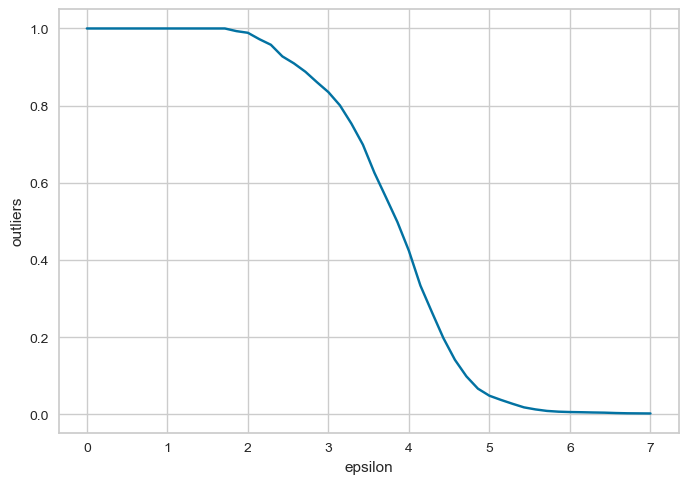

In [87]:
# Outlier proportion vs. eps value lineplot
sns.lineplot(data=models_df, x='epsilon', y='outliers');

In [99]:
# Based on the outlier plot, a reasonable epsilon value would be 6
model = DBSCAN(eps=6, min_samples=min_samples)
model.fit(X_pca)

DBSCAN(eps=6, min_samples=60)

In [ ]:
# Add cluster to dataframe
original_df.insert(1, 'db_cluster', model.labels_)

In [101]:
original_df['db_cluster'].value_counts()

db_cluster
 0    12349
-1       77
Name: count, dtype: int64

#### Analyse clusters

In [102]:
outlier_mask = original_df['db_cluster'] == -1
outliers = original_df[outlier_mask]
outliers

,km_cluster,db_cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,...,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
628,1,-1,1972-03-27,Unlawful Interference,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,1963.0,1 Piston engine,Unknown,Flight,...,Ukraine,Europe,48.571708,39.297315,Destroyed,False,1,1,0.0,Human factor
674,3,-1,1972-05-16,Accident,Antonov AN-24,Soviet Navy - Voyenno-morskoy flot CCCP,1969.0,Multi Turboprop Engines,Ivchenko AI-24,Flight,...,Russia,Asia,54.941755,20.155086,Destroyed,False,8,8,27.0,Human factor
802,4,-1,1972-10-13,Accident,Ilyushin II-62,Aeroflot - Russian International Airlines,1977.0,Multi Jet Engines,Kuznetsov NK-8-4,Landing (descent or approach),...,Russia,Asia,55.960046,37.412964,Destroyed,False,174,174,0.0,Unknown
1276,4,-1,1974-03-03,Accident,Douglas DC-10,Turkish Airlines - THY Türk Hava Yollari,1972.0,Multi Jet Engines,General Electric CF6-6D,Flight,...,France,Europe,49.125875,2.695734,Destroyed,False,346,346,0.0,Technical failure
1466,4,-1,1974-12-04,Accident,Douglas DC-8,Martinair,1966.0,Unknown,P&W JT3D-3B,Landing (descent or approach),...,Sri Lanka,Asia,6.833828,80.572063,Destroyed,False,191,191,0.0,Human factor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11860,4,-1,2020-01-08,Unlawful Interference,Boeing 737-800,Ukraine International Airlines,2016.0,Multi Jet Engines,CFMI CFM56-7B24E,Takeoff (climb),...,Iran,Asia,35.582680,51.113036,Destroyed,False,176,176,0.0,"Terrorism act, hijacking, sabotage, any kind o..."
11909,6,-1,2020-06-15,Unlawful Interference,Gulfstream GII,Private American,1970.0,Multi Jet Engines,Rolls-Royce Spey 511,Landing (descent or approach),...,Venezuela,South America,10.059633,-72.546315,Destroyed,True,2,1,0.0,Human factor
11924,0,-1,2020-08-10,Unlawful Interference,Rockwell Sabreliner 75,Private American,1978.0,Unknown,General Electric CF700-2D2,Flight,...,Venezuela,South America,11.693172,-70.191718,Destroyed,False,2,2,0.0,Human factor
12284,7,-1,2024-01-02,Accident,Airbus A350-900,Japan Airlines,2021.0,Multi Jet Engines,Rolls-Royce Trent XWB-84,Landing (descent or approach),...,Japan,Asia,35.545692,139.776099,Destroyed,True,379,0,0.0,Human factor


In [92]:
outliers.describe()

,km_cluster,db_cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,77.000000,77.0,77,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,4.844156,-1.0,1994-07-18 02:10:54.545454592,1979.246753,23.073317,13.309053,184.038961,117.363636,12.246753
min,0.000000,-1.0,1972-03-27 00:00:00,1952.000000,-27.267429,-90.529021,0.000000,0.000000,0.000000
25%,4.000000,-1.0,1979-05-25 00:00:00,1970.000000,7.178959,-46.655561,12.000000,3.000000,0.000000
50%,4.000000,-1.0,1992-12-21 00:00:00,1977.000000,26.768730,15.253856,213.000000,56.000000,0.000000
75%,7.000000,-1.0,2007-07-17 00:00:00,1986.000000,40.960048,73.065151,290.000000,228.000000,18.000000
max,10.000000,-1.0,2025-02-25 00:00:00,2021.000000,64.955089,142.727438,524.000000,520.000000,180.000000
std,2.176821,0.0,NaN,13.996387,23.683597,67.723550,142.079152,125.890712,27.301993


In [93]:
outliers.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,77,77,77,77,77,77,77,77,77,77,77,77,77,77
unique,3,37,58,5,51,5,11,6,73,45,7,3,2,6
top,Accident,Boeing 747-200,Korean Air,Multi Jet Engines,Unknown,Flight,Scheduled Revenue Flight,Airport (less than 10 km from airport),"Guatemala City-La Aurora, Guatemala",Russia,Asia,Destroyed,False,Human factor
freq,55,8,5,61,11,26,36,27,2,6,29,71,54,38


In [103]:
not_outliers = original_df[~outlier_mask]
not_outliers.sample(5)

,km_cluster,db_cluster,date,category,type,operator,yom,engine,engine_model,flight_phase,...,country,region,latitude,longitude,aircraft_damage,survivors,occupants,fatalities,other_fatalities,cause
4422,1,0,1984-09-16,Accident,PZL-Mielec AN-2,Aeroklub Polskiej Rzeczypospolitej Ludowej - APRL,1976.0,1 Piston engine,Unknown,Takeoff (climb),...,Poland,Europe,50.666818,17.923641,Destroyed,True,25,11,0.0,Unknown
4329,6,0,1984-05-22,Unknown,Piper PA-31-310 Navajo,Private Bolivian,1965.0,Unknown,Unknown,Flight,...,Bolivia,South America,-16.575852,-65.135535,Unknown,True,8,0,0.0,Technical failure
7299,1,0,1995-08-31,Accident,Antonov AN-26,Malian Air Force - Force Aérienne de la Républ...,1974.0,Multi Turboprop Engines,Ivchenko AI-24,Landing (descent or approach),...,Greece,Europe,39.162575,23.479068,Destroyed,False,6,6,0.0,Technical failure
1906,1,0,1976-06-01,Accident,Casa 212 Aviocar,Spanish Air Force - Ejército del Aire,1974.0,Multi Turboprop Engines,Unknown,Unknown,...,Spain,Europe,39.741386,-2.206904,Destroyed,False,0,0,0.0,Unknown
7298,6,0,1995-08-28,Accident,Learjet 24,Medicorp,1966.0,Multi Jet Engines,Unknown,Landing (descent or approach),...,Argentina,South America,-27.375457,-55.915969,Destroyed,True,2,0,0.0,Human factor


In [104]:
not_outliers.describe()

,km_cluster,db_cluster,date,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,12349.000000,12349.0,12349,12349.000000,12349.000000,12349.000000,12349.000000,12349.000000,12349.000000
mean,4.455098,0.0,1993-02-10 18:36:10.669689856,1972.789295,27.146809,-24.399867,13.356628,5.505871,0.048182
min,0.000000,0.0,1970-01-02 00:00:00,1900.000000,-89.991843,-179.491343,0.000000,0.000000,0.000000
25%,2.000000,0.0,1980-02-04 00:00:00,1964.000000,11.423664,-87.909075,2.000000,0.000000,0.000000
50%,3.000000,0.0,1991-05-15 00:00:00,1973.000000,33.656924,-63.086666,4.000000,1.000000,0.000000
75%,7.000000,0.0,2004-12-30 00:00:00,1981.000000,44.526311,35.221713,9.000000,4.000000,0.000000
max,10.000000,0.0,2025-03-17 00:00:00,2023.000000,82.525369,178.719537,340.000000,260.000000,15.000000
std,3.289660,0.0,NaN,15.002968,24.806521,82.624625,30.224687,16.797366,0.527993


In [106]:
not_outliers.select_dtypes(include=['object', 'bool']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,survivors,cause
count,12349,12349,12349,12349,12349,12349,12349,12349,12349,12349,12349,12349,12349,12349
unique,5,494,6771,7,745,6,32,7,7162,198,9,7,2,6
top,Accident,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,Unknown,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Bogotá-El Dorado, Bogotá Capital District",United States of America,North America,Unknown,False,Human factor
freq,6387,568,655,6183,7946,5655,2672,7181,38,3964,4547,5728,6205,5882


#### Observations

**Outliers:** 
Most of the aircrafts have multi jet engines, mostly fatal accidents witl a lot of fatalities.

**Not Outliers:** 
Most of the aircrafts have an unknown engine.

### Compare the different clusterings

The date doesn't seem to be an important factor, whereas the site and the flight phase are important factors. The location is an important factor as well. The DBSCAN seemed to determine the outliers based on the engine (type and model) and the number of fatalities.

## End